## 1. Preparig data

In [2]:
#imports
import os
import time
import uuid
import cv2
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
tf.config.list_physical_devices('GPU')
len(gpus)

0

### 1.1 Loading images form dataset

In [3]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [4]:
img_size = 120

In [14]:
#loading images from datasets
train_images = tf.data.Dataset.list_files('CamData\\AugData\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (img_size,img_size)))
train_images = train_images.map(lambda x: x/255)

In [15]:
test_images = tf.data.Dataset.list_files('CamData\\AugData\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (img_size,img_size)))
test_images = test_images.map(lambda x: x/255)

In [16]:
val_images = tf.data.Dataset.list_files('CamData\\AugData\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (img_size,img_size)))
val_images = val_images.map(lambda x: x/255)

In [17]:
train_images.as_numpy_iterator().next()

array([[[0.0000000e+00, 8.3823532e-02, 1.9607843e-01],
        [4.9019610e-03, 8.7561272e-02, 2.1844363e-01],
        [0.0000000e+00, 7.0588239e-02, 2.0294118e-01],
        ...,
        [7.9411767e-02, 7.1568631e-02, 1.5637255e-01],
        [6.9117650e-02, 7.9901963e-02, 1.5490197e-01],
        [6.4767160e-02, 7.5919114e-02, 1.5533088e-01]],

       [[9.8039221e-04, 9.0870097e-02, 2.0637254e-01],
        [4.9019611e-04, 8.5784316e-02, 2.3174019e-01],
        [0.0000000e+00, 7.7512257e-02, 2.2389705e-01],
        ...,
        [7.0098042e-02, 6.3725494e-02, 1.4607844e-01],
        [7.1017154e-02, 7.3651962e-02, 1.5300246e-01],
        [6.9240198e-02, 7.5612746e-02, 1.6286765e-01]],

       [[1.1090687e-02, 8.5600488e-02, 2.1501225e-01],
        [1.4093138e-03, 7.5919114e-02, 2.0189951e-01],
        [1.1335785e-02, 8.5845590e-02, 2.1182598e-01],
        ...,
        [7.0098042e-02, 7.7941179e-02, 1.6029412e-01],
        [6.6666670e-02, 7.4509807e-02, 1.6470589e-01],
        [6.3848041e-02

### 1.2 Loading labels

In [18]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [19]:
train_labels = tf.data.Dataset.list_files('CamData\\AugData\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [20]:
val_labels = tf.data.Dataset.list_files('CamData\\AugData\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [21]:
test_labels = tf.data.Dataset.list_files('CamData\\AugData\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [22]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.03445, 0.0974 , 0.6997 , 0.947  ], dtype=float16))

### 1.3 Combine images and labels

In [23]:
train_set_size = len(train_images)
val_set_size = len(val_images)
test_set_size = len(test_images)

In [24]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(train_set_size)
train = train.batch(8)
train = train.prefetch(4)

In [25]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(val_set_size)
val = val.batch(8)
val = val.prefetch(4)

In [26]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(test_set_size)
test = test.batch(8)
test = test.prefetch(4)

In [27]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.1298, 0.3218, 0.4644, 0.719 ],
        [0.3037, 0.3467, 0.5913, 0.6875],
        [0.4204, 0.3096, 0.801 , 0.7637],
        [0.    , 0.2418, 0.2041, 1.    ],
        [0.2021, 0.0828, 0.737 , 0.763 ],
        [0.1392, 0.2322, 0.5405, 0.688 ],
        [0.5513, 0.3086, 0.8857, 0.706 ],
        [0.2266, 0.2046, 0.6377, 0.7007]], dtype=float16))

### 1.4 Display example images with labels

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


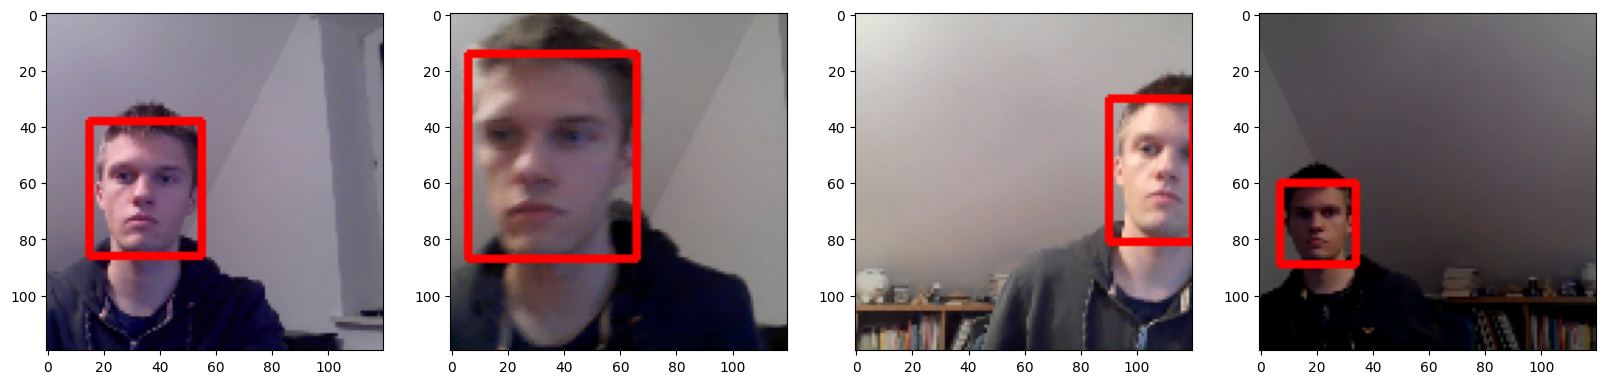

In [28]:
data_samples = train.as_numpy_iterator()
res = data_samples.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [img_size,img_size]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [img_size,img_size]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

## 2. Building model

In [29]:
vgg = VGG16(include_top=False)

In [30]:
def build_model(): 
    input_layer = Input(shape=(img_size,img_size,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [40]:
facetracker = build_model()

In [41]:
facetracker.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 120, 120, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, None, None, 512)      1471468   ['input_4[0][0]']             
                                                          8                                       
                                                                                                  
 global_max_pooling2d_2 (Gl  (None, 512)                  0         ['vgg16[0][0]']               
 obalMaxPooling2D)                                                                                
                                                                                            

In [42]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, weight_decay=lr_decay) 
#zamieniłem decay na weight_decay (decay było przestarzałe), nwm co to robi ale nie wywala errora

In [43]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [44]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

#### Custom model class

In [45]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [46]:
model = FaceTracker(facetracker)
model.compile(opt, classloss, regressloss)

### 1.2 Training model

In [47]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [48]:
hist = model.fit(train, epochs=5, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/5
630/630 [==============================] - 1152s 2s/step - total_loss: 0.3068 - class_loss: 0.0909 - regress_loss: 0.2614 - val_total_loss: 1.2989 - val_class_loss: 0.5295 - val_regress_loss: 1.0341
Epoch 2/5
630/630 [==============================] - 1267s 2s/step - total_loss: 0.0944 - class_loss: 0.0274 - regress_loss: 0.0807 - val_total_loss: 0.1770 - val_class_loss: 0.0089 - val_regress_loss: 0.1726
Epoch 3/5
630/630 [==============================] - 988s 2s/step - total_loss: 0.1065 - class_loss: 0.0284 - regress_loss: 0.0923 - val_total_loss: 0.0354 - val_class_loss: 4.9459e-04 - val_regress_loss: 0.0352
Epoch 4/5
630/630 [==============================] - 904s 1s/step - total_loss: 0.0682 - class_loss: 0.0259 - regress_loss: 0.0552 - val_total_loss: 0.0231 - val_class_loss: 0.0102 - val_regress_loss: 0.0180
Epoch 5/5
630/630 [==============================] - 882s 1s/step - total_loss: 0.0796 - class_loss: 0.0286 - regress_loss: 0.0653 - val_total_loss: 0.1434 - val_

## Short test

1/1 [==============================] - 0s 494ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


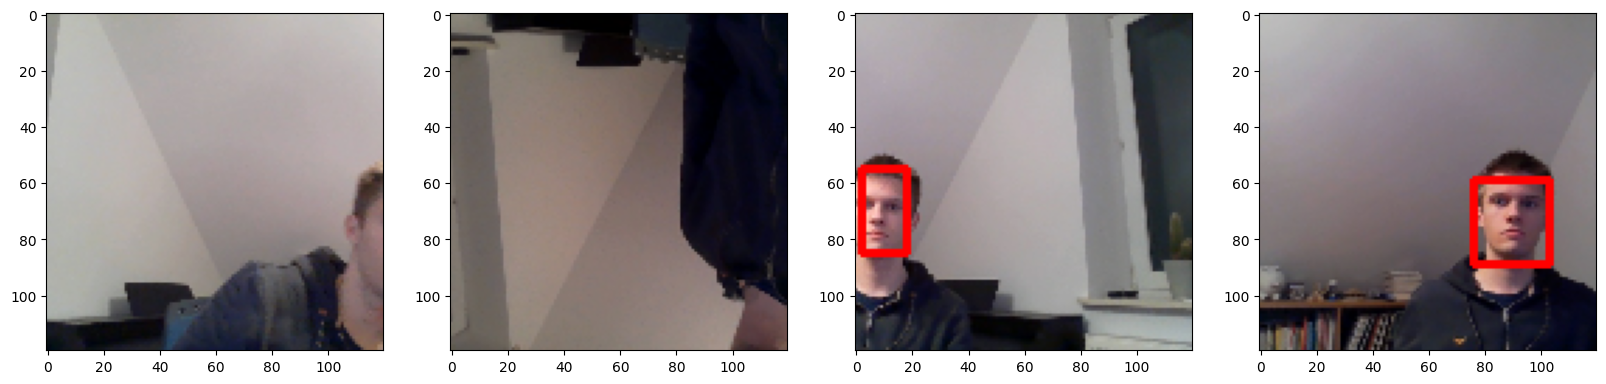

In [49]:
test_data = test.as_numpy_iterator()
test_sample = test_data.next()
yhat = facetracker.predict(test_sample[0])
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [img_size,img_size]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [img_size,img_size]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

### Saving model

In [50]:
from tensorflow.keras.models import load_model
facetracker.save('facetracker.keras')

### Loading model

In [5]:
from tensorflow.keras.models import load_model

In [6]:
facetracker = load_model('facetracker.keras')

### Realtime testing

In [7]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 56ms/step
